In [ ]:
!apt-get update
!apt-get install -y tesseract-ocr
!apt-get install -y poppler-utils
!pip install --upgrade pip
!pip install --no-cache-dir pytesseract pdf2image pymupdf google-auth google-auth-oauthlib google-auth-httplib2 google-api-python-client pandas torchvision transformers
!pip install --upgrade openai
!pip install openai torch torchvision transformers pdf2image pytesseract opencv-python matplotlib


Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,351 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,722 kB]
Get:13 https://r2u.stat.illinois.edu/ubuntu jammy/

In [ ]:
import os
import openai

os.environ["OPENAI_API_KEY"] = "" # put your own GPT api
openai.api_key = os.getenv("OPENAI_API_KEY")

In [ ]:
import re
import pytesseract
import pdf2image
import googleapiclient
import pandas as pd
import torch
import json
from pdf2image import convert_from_path
from transformers import TableTransformerForObjectDetection, DetrImageProcessor

print("All necessary packages are successfully imported!")


All necessary packages are successfully imported!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Replace with your folder path that contains the BC survey
FOLDER_PATH = "/content/drive/My Drive/BC"

def list_pdfs_in_folder(folder_path):
    """List all PDF files in the specified Google Drive folder and return a dictionary {filename: file_path}."""
    if not os.path.exists(folder_path):
        print(f"× Folder '{folder_path}' not found!")
        return {}

    return {f: os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(".pdf")}

# Retrieve PDF files in the specified folder
pdf_files = list_pdfs_in_folder(FOLDER_PATH)


Query Processing

In [ ]:

def classify_queries_with_llm(queries):
    """Classifies multiple queries into predefined categories and extracts the years using GPT-4o."""

    system_prompt = """
    You are an expert in forestry and harvested wood products data classification.
    Your task is to classify each given query into one of four categories and extract the year mentioned in the query.

    ### Categories and Examples

    type_1. Log and Fibre Use or Fibre Flow Pie Chart
       - Queries asking about the volume of logs, sawdust, wood residue, or fibre flow in different mills.
       - Examples:
         - "How much log was used in Lumber Mills in 2015?"
         - "How much log was used in Chip Mills?"
         - "How much lumber production sawdust fibre was used in Pulp and Paper Mills?"
         - "How much wood residue fibre was used in Pellet Mills?"

    type_2. BC Mill Summary Statistics Table
       - Queries about capacity utilization for British Columbia mills.
       - Examples:
         - "What is the capacity utilization for BC Lumber Mill?"
         - "What is the capacity utilization for BC Pellet Mill in 2018?"

    type_3. Estimated Annual Capacity/ Mills List / Location / Administrative Area Table
       - Queries about the estimated annual capacity of various mills.
       - Examples:
         - "What is the estimated annual capacity of Pulp and Paper Mills?"
         - "What was the estimated annual capacity of BC Pellet Mills in 2019?"

    type_4. Estimated Annual Capacity/ Mills List / Location / Administrative Area Table
       - Queries requesting mill lists, company names, locations, administrative areas, or forestry districts.
       - Examples:
         - "What are the mills list and locations for Chip Mills?"
         - "Where are the locations of BC Pellet Mills?"
         - "Which forest districts contain BC Shake and Shingle Mills?"


        Your response MUST be in the exact JSON format below without any additional text or formatting:
    {
        "queries": [
            {
                "query": "original_query_text",
                "category": "type_X",
                "year": "YYYY"
            },
            ...
        ]
    }
    If a query does not contain a recognizable category, return:
    {
        "category": "None",
        "year": "None"
    }
    MAKE SURE type_X is in type_1, type_2, type_3, or type_4.

    Do not include markdown (```json) in your response. The response should be valid raw JSON.
    """

    formatted_queries = "\n".join(queries)

    try:
        response = openai.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": formatted_queries}
            ]
        )

        raw_response = response.choices[0].message.content
        print("Raw API Response:", raw_response)

        # Remove markdown formatting if present
        cleaned_response = re.sub(r"```json|```", "", raw_response).strip()

        # Convert JSON string to dictionary
        result_dict = json.loads(cleaned_response)

        return result_dict.get("queries", [])

    except json.JSONDecodeError:
        print("Error: Failed to parse JSON response.")
        return []
    except openai.error.OpenAIError as e:
        print(f"OpenAI API Error: {e}")
        return []

# Put your queries here
queries = [
    "What is the capacity utilization of pulp Mills in 2015?",
    "How much chips from lumber mills was used in pulp Mills in 2015?",
    "What is the estimated capacity of Shake and Shingle Mills in 2019?",
]

classified_queries = classify_queries_with_llm(queries)

# Print results
for item in classified_queries:
    print(f"Query: {item['query']}")
    print(f"Query Type: {item['category']}")
    print(f"Query Year: {item['year']}")
    print()


Raw API Response: {
    "queries": [
        {
            "query": "What is the capacity utilization of pulp Mills in 2015?",
            "category": "type_2",
            "year": "2015"
        },
        {
            "query": "How much chips from lumber mills was used in pulp Mills in 2015?",
            "category": "type_1",
            "year": "2015"
        },
        {
            "query": "What is the estimated capacity of Shake and Shingle Mills in 2019?",
            "category": "type_3",
            "year": "2019"
        }
    ]
}
Query: What is the capacity utilization of pulp Mills in 2015?
Query Type: type_2
Query Year: 2015

Query: How much chips from lumber mills was used in pulp Mills in 2015?
Query Type: type_1
Query Year: 2015

Query: What is the estimated capacity of Shake and Shingle Mills in 2019?
Query Type: type_3
Query Year: 2019



Retrieve the Corresponding PDF

In [ ]:
import re
def find_pdfs_by_years(years):
    """Find PDF files that match each given year based on the second year in the filename."""
    pdf_matches = {}

    for year in years:
        pdf_matches[year] = None  # Default to None if no match is found
        for file_name, file_path in pdf_files.items():
            # Extract years from the filename
            match = re.findall(r'\d{4}', file_name)
            if len(match) >= 2:  # Ensure the filename contains at least two years
                second_year = match[-1]  # Select the second year in the filename
                if str(year) == second_year:  # Compare with the query year
                    pdf_matches[year] = file_path  # Store the PDF file path
                    break  # Stop searching once a match is found

    return pdf_matches  # Return a dictionary mapping years to PDF file paths

# Extract years from the classified queries
query_years = {item["year"] for item in classified_queries if item["year"] is not None}

# Find the PDFs corresponding to the query years
pdf_paths = find_pdfs_by_years(query_years)

# Print results
for year, pdf_path in pdf_paths.items():
    if pdf_path:
        print(f"Found PDF for {year}: {pdf_path}")
    else:
        print(f"No relevant PDF found for {year}.")

Found PDF for 2015: /content/drive/My Drive/BC/bcflnro-2017-mill-survey-2015.pdf
Found PDF for 2019: /content/drive/My Drive/BC/bcflnrord-2021-mill-survey-2019.pdf


Convert PDF Pages to Images

In [ ]:
import io
from pdf2image import convert_from_path

def convert_pdf_to_images(pdf_path):
    """Converts a PDF file (given by path) to images without saving the PDF."""
    try:
        images = convert_from_path(pdf_path)  # Convert PDF to images
        print(f"Converted '{pdf_path}' to {len(images)} images.")
        return images
    except Exception as e:
        print(f"Error converting PDF '{pdf_path}': {e}")
        return []

# Dictionary to store images for each query year
pdf_images = {}

for year, pdf_path in pdf_paths.items():
    if pdf_path:
        print(f"Processing PDF for {year}: {pdf_path}")

        # Convert PDF file to images
        pdf_images[year] = convert_pdf_to_images(pdf_path)
    else:
        print(f"No relevant PDF found for {year}.")


Processing PDF for 2015: /content/drive/My Drive/BC/bcflnro-2017-mill-survey-2015.pdf
Converted '/content/drive/My Drive/BC/bcflnro-2017-mill-survey-2015.pdf' to 51 images.
Processing PDF for 2019: /content/drive/My Drive/BC/bcflnrord-2021-mill-survey-2019.pdf
Converted '/content/drive/My Drive/BC/bcflnrord-2021-mill-survey-2019.pdf' to 55 images.


Extract Relevant Pages Using gpt4o

Processing OCR for years: 100%|██████████| 2/2 [00:01<00:00,  1.82it/s]


Query: What is the capacity utilization of pulp Mills in 2015? (Category: type_2) - Selected Relevant Pages: [26]


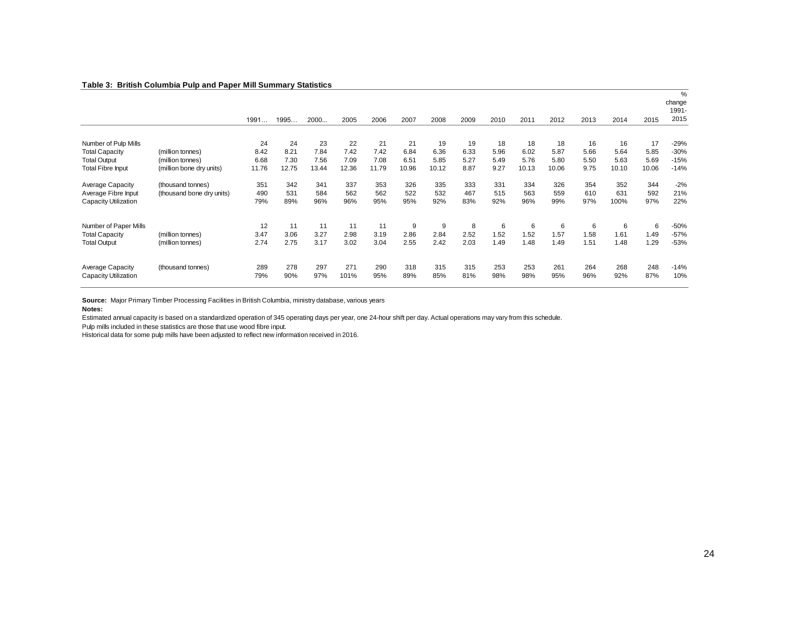

Query: How much chips from lumber mills was used in pulp Mills in 2015? (Category: type_1) - Selected Relevant Pages: [11]


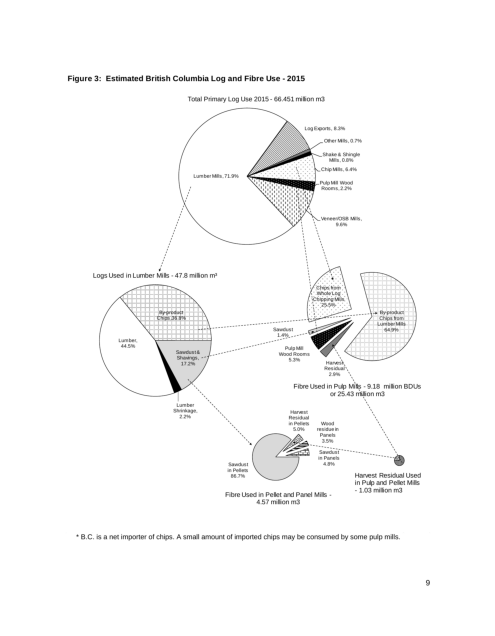

Query: What is the estimated capacity of Shake and Shingle Mills in 2019? (Category: type_3) - Selected Relevant Pages: [55]


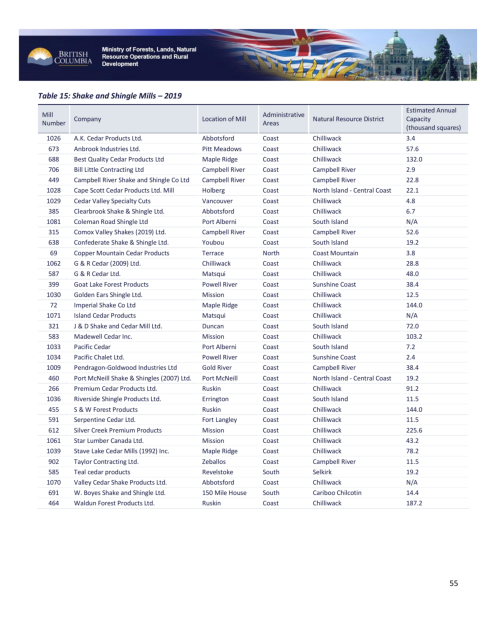

In [ ]:
import openai
import pytesseract
import json
import re
import os
import base64
import matplotlib.pyplot as plt
import cv2
from io import BytesIO
import numpy as np
import pandas as pd
from collections import Counter
from PIL import Image
from tqdm import tqdm


def encode_image(pil_image):
    buffer = BytesIO()
    pil_image.save(buffer, format='PNG')
    buffer.seek(0)
    return base64.b64encode(buffer.read()).decode('utf-8')


def extract_text_from_image(image):
    """Extracts OCR text from an image using Tesseract."""
    return pytesseract.image_to_string(image)


def extract_table_from_image_with_GPT(image):
    """Detects and extracts table-like structures from an image using OCR with positional data."""
    base64_image = encode_image(image)
    system_prompt = """You are a helpful assistant. You will be presented with one screenshot of one page in a book. Your task is to determine whether this
    page has a table. Please answer based on your closed observation. Provide you answer in yes or no. For example: yes. Now, provide your answer: """
    response = openai.chat.completions.create(
        model="gpt-4o",
        messages=[
            {"role": "system", "content": system_prompt},
            {
            "role": "user",
            "content": [
              {
                "type": "image_url",
                "image_url": {
                  "url": f"data:image/jpeg;base64,{base64_image}"
                }
              }
              ]}],
        temperature=0
    )
    raw_response = response.choices[0].message.content


    return "yes" in raw_response.lower()



def find_relevant_pages_with_llm(images_dict, classified_queries, iterations=10, cache_dir="test/cache/", overwrite=True):
    """Uses OCR and an LLM to identify the most relevant pages for given queries in a set of PDF images."""
    extracted_texts = {}

    # Extract text from images or load from cache
    for year in tqdm(images_dict, desc="Processing OCR for years"):
        cache_path = os.path.join(cache_dir, f"{year}.json")

        if os.path.exists(cache_path) and not overwrite:
            with open(cache_path, "r", encoding="utf-8") as f:
                try:
                    extracted_texts[year] = json.load(f)
                except json.JSONDecodeError:
                    print(f"Warning: Failed to load JSON for {year}. Running OCR instead.")
                    extracted_texts[year] = []
        else:
            extracted_texts[year] = []
            for i, img in tqdm(enumerate(images_dict[year]), total=len(images_dict[year]), desc=f"OCR for {year}"):
                full_text = extract_text_from_image(img)
                has_table = extract_table_from_image_with_GPT(img)
                print(i + 1, has_table)
                extracted_texts[year].append({
                    "image_index": i + 1,
                    "text": full_text,
                    "has_table": has_table  # Marks whether this page has a table
                })

            os.makedirs(os.path.dirname(cache_path), exist_ok=True)
            with open(cache_path, "w", encoding="utf-8") as f:
                json.dump(extracted_texts[year], f, indent=4)

    inctruction_prompt = """
    You are an expert in document analysis. Your task is to identify the **most relevant pages** from a set of PDF reports
    based on multiple queries and their respective categories.

    ### **Instructions:**
    - **Return only pages containing figures, pie charts, or tables** relevant to the query.
    - **Use `query_category` to determine what type of table or figure to extract.**
    - **Use `query` to determine the specific type of mill.**
    - **Ensure that the extracted pages match the associated year.**
    - If no relevant page is found for a query, return `"relevant_image_indices": []`.
    ---

    ### **Query Categories & Page Identification Rules:**"""

    category1_prompt = """
    #### **1. Log and Fibre Use or Fibre Flow Pie Chart (category=type_1)**
    - Find the **exact page containing the pie chart** for log and fibre use.
    - Pages **be included** if it contains **"Figure 3: Estimated British Columbia Log and Fibre Use - Year"**.

    ---"""
    category2_prompt = """
    #### **2. BC Mill Summary Statistics Table (category=type_2)(has_table=True)**
    - Find the **specific table summarizing capacity utilization** for British Columbia mills.
    - The table should correspond to the **mill type mentioned in the query** (e.g., **Lumber Mill, Pulp Mill, Pellet Mill**).
    - Relevant tables include:
        - **"Table 1: British Columbia Lumber Mill Summary Statistics"**
        - **"Table 2: British Columbia Veneer Mill Summary Statistics"**
        - **"Table 3: British Columbia Pulp and Paper Mill Summary Statistics"**
        - **"Table 4: British Columbia Pellet Mill Summary Statistics"**
        - **"Table 5: BC Veneer Mill Summary Statistics for Mills with an Annual Log Consumption of at Least 25,000 Cubic Metres"**
    - **Do NOT return table of content pages.**
    - **Do NOT return pages if a page contains: "Time Series Data".**


    ---"""
    category34_prompt = """
    #### **3. Mills List / Location / Administrative Area Table (category=type_3 or category==type_4)(has_table=True)**

    ##### **Query Rules:**
    - The **ONLY** role of the query is to specify the **mill type** (e.g., Lumber Mill, Pulp Mill, Pellet Mill, etc.).
    - "What is the estimated capacity of pulp and paper Mills in 2019?" (Extract data for **pulp and paper Mills**)
    - "What is the location of BC panel Mills in 2019?" (Extract data for **panel Mills**)

    ##### **Inclusion Criteria:**
    **tabel pages **be included** if it contains similar header:
    - "Table 8: Lumber Mills with Capacity at Least 40 Million Board Feet"
    - "Table 9: Lumber Mills with Capacity Less than 40 Million Board Feet"
    - "Table 10: Pulp and paper Mills"
    - "Table 11: Veneer, Plywood, OSB, and Panel Mills"

    **tabel pages **be included** if it contains following columns (or similar terms):
    - "Location"
    - "Company"
    - "Ltd."
    - "Administrative Area"
    - "Natural Resources District"
    - "Annual estimated capapcity"
    - "Administrative Natural Resource"

    **Common Page Characteristics:**
    - The table typically **lists multiple mills** with structured rows containing numerical or categorical values.
    - **Mill name** is formatted as "XYZ Forest Products Ltd." or similar.
    - **Mill number** is usually a number from 1 to 999
    - Each row **corresponds to a single mill**, providing location, administrative details, and capacity estimates.

    ##### **Exclusion Criteria:**
    A page **be excluded** if it tabel contains the following terms:
    - "Mill Summary Statistics"
    - "Source: Major Primary Timber Processing Facilities in British Columbia, ministry database, various years"
    - "Note: Output Capacity is estimated based on"
    - "Capacity Utilization"
    - "Recovery Factor"
    - "% change"
    - "Total Input"
    - "Total Output"

    Additionally, exclude:
    - Pages with **maps**.
    - **Even if a page contains a table, it must be excluded if any of the above exclusion terms are present.**

    ##### **Multi-Page Handling (Ensuring Continuous Table Extraction)**
    **General Extraction Rules**
    - **Extraction must start from the first detected table of a given mill type and include all its pages.**
    - **STOP ONLY when a different wood product mill type hearder appears.** INCLUDE all pages explicitly labeled with the target mill type. Also INCLUEDE adjacent flowing pages without headers if they still belong to the same mill type.
    - **Wood product mill type is the key factor that differenitates tables. For example, "Table 8: Lumber Mills with Capacity at Least 40 Million Board Feet" and "Table 9: Lumber Mills with Capacity Less than 40 Million Board Feet" are both about "Lumber Mills", so BOTH TABLES should be RETURNED.
    - **Do NOT stop extracting tables mid-section**; ensure all pages related to the current mill type are included before moving to the next type of mills.

    ---"""

    category_prompt = {
        "type_1": category1_prompt,
        "type_2": category2_prompt,
        "type_3": category34_prompt,
        "type_4": category34_prompt,
    }
    format_prompt = """
    ### **Response Format**
    ```json
    {
        "query_results": [
            {
                "query": "original_query_text",
                "year": "YYYY",
                "category": "category_type",
                "relevant_image_indices": [list of image indices]
            }
        ]
    }
    ```
    Now, based on the extracted text, **determine the most relevant pages**.
    """

    all_results = {query["query"]: [] for query in classified_queries}
    query_year = {d["query"]: d["year"] for d in classified_queries}

    # Dictionary to store frequency of page occurrences
    page_frequencies = {query["query"]: Counter() for query in classified_queries}

    for _ in range(iterations):
        try:
            queries_with_categories = [
                {"query": q["query"], "category": q["category"], "year": q["year"]}
                for q in classified_queries
            ]

            for query_with_cat_i in queries_with_categories:
                while True:
                  try:
                    year = query_with_cat_i["year"]
                    filtered_extracted_texts = {
                          year: [
                              {k: v for k, v in page.items() if k in ["image_index", "text", "has_table"]}
                              for page in extracted_texts[year]
                              if (query_with_cat_i["category"] in ["type_2", "type_3", "type_4"] and page["has_table"])
                              or query_with_cat_i["category"] not in ["type_2", "type_3", "type_4"]
                          ]
                      }
                    category = query_with_cat_i["category"]
                    system_prompt = inctruction_prompt + category_prompt[category] + format_prompt
                    response = openai.chat.completions.create(
                        model="gpt-4o",
                        messages=[
                            {"role": "system", "content": system_prompt},
                            {"role": "user", "content": json.dumps({
                                "queries": [query_with_cat_i],
                                "Extracted Pages": filtered_extracted_texts  # Uses filtered pages
                            })}
                        ],
                        temperature=0
                    )


                    raw_response = response.choices[0].message.content
                    json_match = re.search(r"\{.*\}", raw_response, re.DOTALL)
                    if json_match:
                        cleaned_response = json.loads(json_match.group(0))
                        break
                    else:
                        print("Warning: No valid JSON detected in response.")
                        continue
                  except Exception as e:
                    print(f" {e}")

                    continue

                for res in cleaned_response.get("query_results", []):
                    query = res["query"]
                    indices = res.get("relevant_image_indices", [])

                    # Track how often each page index appears across all runs
                    page_frequencies[query].update(indices)

        except (json.JSONDecodeError, openai.OpenAIError, AttributeError) as e:
            print(f"Error: {e}")
            continue

    # Select the pages that appeared most frequently
    final_results = []
    for query, counter in page_frequencies.items():
        # Sort by occurrence frequency (descending), keeping most common pages
        sorted_indices = [idx for idx, count in counter.most_common()]
        final_results.append({
            "query": query,
            "relevant_image_indices": sorted_indices,  # Now returns pages with highest frequency
            "category": next((q["category"] for q in classified_queries if q["query"] == query), ""),
            "year": query_year[query]
        })

    return final_results

def display_relevant_images(images_dict, query_results):
    """Displays relevant images based on extracted indices for each query."""
    for result in query_results:
        query_text = result["query"]
        query_category = result["category"]
        relevant_image_indices = result.get("relevant_image_indices", [])

        if not relevant_image_indices:
            print(f"Query: {query_text} (Category: {query_category}) - No relevant pages found.")
            continue

        print(f"Query: {query_text} (Category: {query_category}) - Selected Relevant Pages: {relevant_image_indices}")
        year = result["year"]

        for idx in relevant_image_indices:
            if idx <= len(images_dict[year]):  # Ensure index exists
                img = images_dict[year][idx - 1]
                plt.figure(figsize=(10, 8))
                plt.imshow(img)
                plt.axis("off")
                plt.show()

# Define cache directory and execute functions
cache_dir = "/content/drive/MyDrive/HWP_LLM/" # Replace with your folder path that you want to save the json file for the BC survey
query_results = find_relevant_pages_with_llm(pdf_images, classified_queries, iterations=1, cache_dir=cache_dir, overwrite=False)
display_relevant_images(pdf_images, query_results)


Answer the query

In [ ]:
import io
import base64
import re
import json
import os
from decimal import Decimal
import pandas as pd
import openai
from collections import Counter

def encode_image_to_base64(image):
    """Converts an image to base64 format for sending to OpenAI's GPT-4o Vision."""
    buffered = io.BytesIO()
    image.save(buffered, format="PNG")
    return base64.b64encode(buffered.getvalue()).decode()

def run_gpt_query_multiple_times(prompt, query_content, images, num_runs=1, response_format={ "type": "text"}):
    """
    Runs the same GPT query multiple times and returns the most frequent response.
    """
    responses = []
    for _ in range(num_runs):
        response = openai.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "system", "content": prompt},
                {"role": "user", "content": query_content},
                {"role": "user", "content": [
                    {"type": "image_url", "image_url": {"url": f"data:image/png;base64,{encode_image_to_base64(images[0])}"}}
                ]}
            ],
            temperature=0,
            response_format=response_format
        )
        responses.append(response.choices[0].message.content.strip())

    # Find the most frequent response
    most_frequent_answer = Counter(responses).most_common(1)[0][0]
    return most_frequent_answer

def process_queries(queries, classified_queries, pdf_images, query_results):
    """Processes multiple queries, runs GPT-4o multiple times, and selects the most frequent answer."""
    results = {}

    # Ensure classified queries are mapped correctly
    query_mapping = {item["query"]: item for item in classified_queries}

    for query_text in queries:
        if query_text not in query_mapping:
            print(f"Query '{query_text}' not found in classified queries.")
            results[query_text] = "No relevant information found."
            continue

        query_data = query_mapping[query_text]
        query_category = query_data.get("category", "None")
        year = query_data.get("year", "None")

        # Retrieve relevant pages from query_results
        relevant_pages = []
        for res in query_results:
            if res["query"] == query_text:
                relevant_pages = res.get("relevant_image_indices", [])
                break

        if not relevant_pages or year not in pdf_images:
            print(f"No relevant pages found for query '{query_text}' in year {year}.")
            results[query_text] = "No relevant information found."
            continue

        images = [pdf_images[year][idx - 1] for idx in relevant_pages]

        # Select the correct processing function based on query category
        if query_category == "type_1":
            results[query_text] = process_query_1(images, query_text)
        elif query_category == "type_2":
            results[query_text] = process_query_2(images, query_text)
        elif query_category == "type_3":
            results[query_text] = process_query_3(images, query_text)
        elif query_category == "type_4":
            results[query_text] = process_query_4(images)
        else:
            results[query_text] = "No relevant type."

    return results



def process_query_1(images, query):

    # prompt = """
    # You are an expert in analyzing pie charts.
    # Extract the total amount and corresponding percentage **ONLY for the mills mentioned in the query**.
    # Compute the final value.

    # **Format the output as follows:**
    # "Total Amount: X million × Percentage: Y% = Computed Value: Z million m³ log use."
    # OR
    # "Total Amount: X million × Percentage: Y% = Computed Value: Z million m³ fibre use."

    # If no relevant data is found, return: "No relevant information found."
    # """

    prompt = """
    You are an expert in analyzing pie charts.
    Extract the total amount and corresponding percentage **ONLY for the mills mentioned in the query**.
    Compute the final value.
    **Total Amount × Percentage = Computed Value**

     The material use must be classified as either **"log"** or **"fibre"**, based on the query context:
    - If the material mentioned relates to logs flow，classify it as **"log"**.
    - If the material mentioned relates to fibre flow, classify it as **"fibre"**.

    Please return a json dictionary. Each key is the material use name and each value is a tuple of (total amount, percentage, computed_value).

    Example1:
    - Query: In 2012, How much log was used in Lumber Mills？
    - Pie chart shows "Total Primary Log Use 2012 - 66.42 million m³"
      and a section labeled "Lumber Mills 72.9%".
    - Example1 Output:
    {
      "log": (66.42, 72.9, 48.42018)
    }
    Example2:
    - Query: In 2012, How much fibre was used in pulp mills from lumber mills？
    - Pie chart shows "Fibre Used in Pulp Mills - 9.18 million BDUs or 25.43 million m3"
      and a section labeled "By-product Chips from Lumber Mlls 64.9%".
    - Example2 Output:
    {
      "fibre": (25.43, 64.9, 16.50407)
    }
    Only return the json dictonary, do not use other words.
    """

    results = run_gpt_query_multiple_times(prompt, query, images, response_format={"type": "json_object"})
    results = json.loads(results)

    def calculate_value(total_amount, percentage):
        """Computes the final value based on extracted total amount and percentage."""
        return total_amount * (percentage / 100)

    final_results = []

    # if isinstance(results, list) and all(isinstance(item, list) for item in results):
    #     results = ["".join(item) for item in results]  # Join character lists into full strings

    for result in results:
        # if isinstance(result, list):
        #     result = "".join(result).strip()  # Convert character list into full string

        if "No relevant information found" in result:
            final_results.append(result)
            continue

        try:
            # Extract total amount (X) and percentage (Y)
            # match = re.search(r"Total Amount:\s*([\d,\.]+)\s*million\s*×\s*Percentage:\s*([\d,\.]+)%", result)
            total_amount, percentage = results[result][0], results[result][1]
            computed_value = calculate_value(total_amount, percentage)

            final_results.append(
                    f"Total Amount: {total_amount} million × Percentage: {percentage}% = Computed Value: {computed_value:.4f} million m³ {result} use."
                )
        except Exception as e:
            final_results.append(f"Error in calculation: {str(e)}")

    return final_results


def process_query_2(images, query):
    prompt = f"""
    You are an expert in structured data extraction from tables.
    Extract **ONLY the relevant mill capacity utilization data** for the requested year and mill type.

    **Format the output as follows:**
    "In year X, capacity utilization for Y: Z%."

    **Examples:**
    "In year 2013, capacity utilization for coast lumber mills 100%, interior lumber mills: 92%, province lumber mills: 98%."
    "In year 1998, capacity utilization for veneer mills: 94%."

    If no relevant data is found, return: "No relevant information found."
    """
    return run_gpt_query_multiple_times(prompt, query, images)


import re
from decimal import Decimal

def process_query_3(images, query):
    """Processes all pages, extracting and summing values from the 'Estimated Annual Capacity' column along with units."""

    prompt = """
    You are an expert in table extraction. Analyze the table(s) from the provided image and extract **only** numerical values along with their corresponding units.

    **Instructions:**
    - Extract values **accurately** from the 'Estimated Annual Capacity' column.
    - Identify the 'unit' directly following 'Estimated Annual Capacity' (e.g., 'million board feet', 'thousand tonnes').

    **Key Extraction Task:**
    - Read and extract **all numerical values** from the 'Estimated Annual Capacity' column. Please make sure you extracted all of them, WITHOUT MISSING OUT ANY VALUE.
    - Extract the corresponding unit.

    **Output Format:**
    - Return a json dictionay, the keys include "values" and "unit". The "values" is the comprehensive list of the values you extracted, and the "unit" is the one you identified.
    - If relevant data is found, return:

      {"values": [value1, value2, value3, ...], "unit": [u]}.

    - If no relevant data is found on a page, return an empty json dictionary {}
    - Only give the json dictionary, do not use other words.
    """

    extracted_values = []
    unit_set = set()  # Store unique units

    for i, image in enumerate(images):
        formatted_prompt = prompt.replace("Page X", f"Page {i+1}")
        result = run_gpt_query_multiple_times(formatted_prompt, "", [image], response_format={"type": "json_object"})
        result = json.loads(result)
        if len(result) == 0:
            continue  # Skip pages without tables

        # Extract numerical values
        extracted_numbers_de = result["values"]
        extracted_values.extend(extracted_numbers_de)

        # Extract unit
        unit_match = result["unit"][0]
        if unit_match:
            unit_set.add(unit_match)

    if not extracted_values:
        return "No relevant information found."

    # Compute total using Decimal to preserve precision
    total_capacity = sum(extracted_values)

    # Determine unit (assuming unit consistency across pages)
    final_unit = ", ".join(unit_set) if unit_set else "unknown unit"

    output = f"""
Extracted Annual Estimated Capacity values from all pages: {extracted_numbers_de}
Total Annual Estimated Capacity: {total_capacity} {final_unit}.
    """

    return output




def process_query_4(images):
    """Processes all pages, extracting and printing structured tabular data."""
    prompt = """
    You are an expert in table extraction. Analyze the provided image and extract structured tabular data.

    **Instructions:**
    - Identify and extract **all relevant tables** from the image.
    - Ensure **data accuracy** in extraction.
    - Maintain a **structured format** when presenting tabular data.

    **Output Formatting Rules:**
    - If relevant data is found, return the extracted table.
    - If no relevant data is found, return **exactly**:
      "No table found, skipping page."
    - Example output is:
    | Mill Number | Company                                           | Location of Mill | Administrative Area | Natural Resource District | Estimated Annual Capacity (million board feet) |
    |-------------|---------------------------------------------------|------------------|---------------------|---------------------------|-----------------------------------------------|
    | 498         | Aspen Planers Ltd.                                | Merritt          | South               | Cascades                  | 192                                           |
    | 213         | Babine Forest Products Limited (Hampton Lumber)   | Burns Lake       | North               | Nadina                    | 224
    - DO NOT USE any other texts, such as ```plaintext or ```markdown or ```
    """

    extracted_tables = ["Extracted Tables"]

    for i, image in enumerate(images):
        formatted_prompt = prompt.replace("Page X", f"Page {i+1}")
        result = run_gpt_query_multiple_times(formatted_prompt, "Extract structured table", [image])

        if "No table found, skipping page." in result:
            continue  # Skip pages without tables

        extracted_tables.append(f"{result}")

    if not extracted_tables:
        print("No relevant information found.")
        return None

    structured_output = "\n\n".join(extracted_tables)
    return structured_output


def parse_table(table_str: str):
    lines = table_str.strip().splitlines()
    # First line is the header row; ignore the outer '|' columns
    header_parts = lines[0].split('|')[1:-1]
    columns = [h.strip() for h in header_parts]

    # The second line is the dashed separator; skip it
    data_lines = lines[2:]

    data = []
    for line in data_lines:
        # Split each row, again ignoring the outer empty columns
        parts = line.split('|')[1:-1]
        row_values = [p.strip() for p in parts]
        # Make sure the row length matches header length
        if len(row_values) == len(columns):
            data.append(row_values)

    return columns, data

def sanitize_filename(filename):
    """Sanitize query text to be a valid filename by removing invalid characters."""
    return re.sub(r'[\/:*?"<>|]', '_', filename)

# Process Queries
results = process_queries(queries, classified_queries, pdf_images, query_results)

# Save CSV files
for query, answer in results.items():
    print(f"Query: {query}\nAnswer: {answer}\n")

    if "Extracted Tables" in answer:
        csv_rows, columns = [], None
        table_str_list = answer.split("\n\n")

        for table_str in table_str_list[1:]:
            if not columns:
                columns, rows_i = parse_table(table_str)
            else:
                _, rows_i = parse_table(table_str)
            csv_rows += rows_i

        csv_dict = {columns[i]: [row[i] for row in csv_rows] for i in range(len(columns))}
        df = pd.DataFrame(csv_dict)

        sanitized_query = sanitize_filename(query)
        save_path = f"test/{sanitized_query}.csv"
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        df.to_csv(save_path, index=False)

        print(f"Saved CSV file: {save_path}")

Query: What is the capacity utilization of pulp Mills in 2015?
Answer: In year 2015, capacity utilization for pulp mills: 97%.

Query: How much chips from lumber mills was used in pulp Mills in 2015?
Answer: ['Total Amount: 25.43 million × Percentage: 64.9% = Computed Value: 16.5041 million m³ fibre use.']

Query: What is the estimated capacity of Shake and Shingle Mills in 2019?
Answer: 
Extracted Annual Estimated Capacity values from all pages: ['3.4', '57.6', '132.0', '2.9', '22.8', '22.1', '4.8', '6.7', '52.6', '19.2', '3.8', '28.8', '48.0', '38.4', '12.5', '144.0', '72.0', '103.2', '7.2', '2.4', '38.4', '19.2', '91.2', '11.5', '144.0', '11.5', '225.6', '43.2', '78.2', '11.5', '19.2', '14.4', '187.2']
Total Annual Estimated Capacity: 1679.5 thousand squares.
    

